In [1]:
import os
import wave
import numpy as np
import csv
from scipy.signal import butter, sosfilt
import math
import matplotlib.pyplot as plt

#########################################
# Utility Functions for Reading and Processing
#########################################

def derive_output_csv_path(input_wav_path, output_dir):
    """
    Given an input WAV file path and an output directory, produce a corresponding CSV file path.
    Example:
    input_wav_path = "data/RAW/CAFE-CAFE-1_clean.wav"
    output_dir = "output_csv/"
    result -> "output_csv/CAFE-CAFE-1_clean.csv"
    """
    base_name = os.path.basename(input_wav_path)       # CAFE-CAFE-1_clean.wav
    name_no_ext = os.path.splitext(base_name)[0]       # CAFE-CAFE-1_clean
    output_path = os.path.join(output_dir, f"{name_no_ext}.csv")
    return output_path

def read_wav(file_path):
    """
    Read a 2-channel .wav file and return mono signal (averaged channels).
    Check that the sample rate is 48kHz and raise ValueError if not.
    
    Parameters:
        file_path (str): Path to the .wav file.
    
    Returns:
        mono_signal (np.ndarray): Mono audio data as float32.
        sample_rate (int): Sampling rate of the audio file (should be 48000).
    """
    with wave.open(file_path, 'rb') as wav_file:
        num_channels = wav_file.getnchannels()
        sample_rate = wav_file.getframerate()
        num_frames = wav_file.getnframes()

        # Check sample rate
        if sample_rate != 48000:
            raise ValueError(f"Expected 48kHz sample rate, got {sample_rate}Hz")

        # Check channels
        if num_channels != 2:
            raise ValueError("Expected 2 channels for stereo input.")

        frames = wav_file.readframes(num_frames)
        audio_data = np.frombuffer(frames, dtype=np.int16)
        audio_data = audio_data.reshape(-1, num_channels)
        mono_signal = audio_data.mean(axis=1).astype(np.float32)
        return mono_signal, sample_rate

def cut_to_31_minutes(mono_signal, sample_rate):
    """
    Cut the mono signal to the first 31 minutes.
    """
    max_samples = 31 * 60 * sample_rate
    return mono_signal[:max_samples]

def butter_bandpass(lowcut, highcut, fs, order=5):
    """
    Create a bandpass filter in SOS form.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos

def create_filter_banks(sample_rate, num_filters=16, low_freq=50, high_freq=8000):
    """
    Create a filter bank of bandpass filters, log-spaced between low_freq and high_freq.
    
    Returns:
        filter_banks (list): List of SOS filters.
        frequencies (np.ndarray): The edges of the frequency bands.
    """
    frequencies = np.logspace(np.log10(low_freq), np.log10(high_freq), num_filters + 1)
    filter_banks = []
    for i in range(num_filters):
        sos = butter_bandpass(frequencies[i], frequencies[i+1], sample_rate, order=5)
        filter_banks.append(sos)
    return filter_banks, frequencies

def apply_filter_bank(signal, filter_banks):
    """
    Apply each filter in the filter bank to the signal.
    """
    filtered_signals = []
    for sos in filter_banks:
        filtered = sosfilt(sos, signal)
        filtered_signals.append(filtered)
    return np.array(filtered_signals)

def compute_instantaneous_power(filtered_signals):
    """
    Compute instantaneous power = amplitude^2.
    """
    power_signals = filtered_signals**2
    return power_signals

def quantize_time(power_signals, sample_rate, time_bin_ms=1):
    """
    Quantize the power signals to 1ms time bins by averaging every 48 samples.
    """
    samples_per_bin = int((sample_rate/1000) * time_bin_ms)  # 48 for 48kHz
    num_filters, num_samples = power_signals.shape
    num_bins = num_samples // samples_per_bin
    trimmed_samples = num_bins * samples_per_bin
    power_signals = power_signals[:, :trimmed_samples]
    reshaped = power_signals.reshape(num_filters, num_bins, samples_per_bin)
    quantized_signals = reshaped.mean(axis=2)
    return quantized_signals

def normalize_log2_scale(quantized_signals):
    """
    Normalize each channel's power onto a 0-15 log2 scale.
    Baseline of 1 maps to 0, max power maps to 15.
    """
    num_filters, num_bins = quantized_signals.shape
    normalized_signals = np.zeros_like(quantized_signals, dtype=np.int32)
    
    for f in range(num_filters):
        channel_power = quantized_signals[f, :]
        channel_power = np.maximum(channel_power, 1.0)
        max_power = channel_power.max()
        if max_power == 1:
            normalized_signals[f, :] = 0
        else:
            factor = 15.0 / math.log2(max_power)
            logs = np.log2(channel_power)
            scaled = np.floor(logs * factor)
            scaled = np.clip(scaled, 0, 15)
            normalized_signals[f, :] = scaled.astype(np.int32)
    return normalized_signals

def save_to_csv(normalized_signals, output_path):
    """
    Save the normalized signals to CSV file.
    Rows = time bins
    Columns = frequency channels
    """
    data_to_save = normalized_signals.T
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'w', newline='') as f:
        writer = csv.writer(f)
        for row in data_to_save:
            writer.writerow(row)

def process_audio_file(input_wav_path, output_dir):
    """
    Process an audio file and save the resulting normalized data to a CSV file.
    Returns intermediate data for plotting if needed.
    """
    # Derive output CSV path
    output_csv_path = derive_output_csv_path(input_wav_path, output_dir)

    mono_signal, sample_rate = read_wav(input_wav_path)
    trimmed_signal = cut_to_31_minutes(mono_signal, sample_rate)
    filter_banks, freqs = create_filter_banks(sample_rate, num_filters=16, low_freq=50, high_freq=8000)
    filtered = apply_filter_bank(trimmed_signal, filter_banks)
    power_signals = compute_instantaneous_power(filtered)
    quantized = quantize_time(power_signals, sample_rate, time_bin_ms=1)
    normalized = normalize_log2_scale(quantized)
    save_to_csv(normalized, output_csv_path)
    return mono_signal, trimmed_signal, filtered, power_signals, quantized, normalized, freqs, output_csv_path


#########################################
# Plotting Functions
#########################################

def plot_mono_signal(mono_signal, sample_rate, start_sec=0, duration_sec=1):
    start_sample = int(start_sec * sample_rate)
    end_sample = start_sample + int(duration_sec * sample_rate)
    segment = mono_signal[start_sample:end_sample]
    times = np.arange(start_sample, end_sample) / sample_rate

    plt.figure(figsize=(10, 4))
    plt.plot(times, segment)
    plt.title('Mono Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def plot_filtered_signal_one_channel(filtered_signals, sample_rate, frequencies, channel=0, start_sec=0, duration_sec=1):
    """
    Plot a portion of the filtered signal for a single frequency channel.
    Also include frequency range in title, truncated to integers.
    """
    start_sample = int(start_sec * sample_rate)
    end_sample = start_sample + int(duration_sec * sample_rate)
    segment = filtered_signals[channel, start_sample:end_sample]
    times = np.arange(start_sample, end_sample) / sample_rate

    low_f = int(frequencies[channel])
    high_f = int(frequencies[channel+1])
    plt.figure(figsize=(10, 4))
    plt.plot(times, segment)
    plt.title(f'Filtered Signal - Channel {channel} [{low_f} - {high_f}] Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def plot_power_signal_one_channel(power_signals, sample_rate, frequencies, channel=0, start_sec=0, duration_sec=1):
    """
    Plot a portion of the instantaneous power signal for a single frequency channel.
    Include frequency range in title.
    """
    start_sample = int(start_sec * sample_rate)
    end_sample = start_sample + int(duration_sec * sample_rate)
    segment = power_signals[channel, start_sample:end_sample]
    times = np.arange(start_sample, end_sample) / sample_rate

    low_f = int(frequencies[channel])
    high_f = int(frequencies[channel+1])
    plt.figure(figsize=(10, 4))
    plt.plot(times, segment)
    plt.title(f'Power Signal - Channel {channel} [{low_f} - {high_f}] Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Power')
    plt.show()

def plot_quantized_signal_one_channel(quantized_signals, frequencies, channel=0, start_ms=0, duration_ms=1000):
    """
    Plot a portion of the quantized signal for one channel.
    Include frequency range in title.
    """
    start_bin = start_ms
    end_bin = start_ms + duration_ms
    segment = quantized_signals[channel, start_bin:end_bin]
    times = np.arange(start_bin, end_bin) / 1000.0

    low_f = int(frequencies[channel])
    high_f = int(frequencies[channel+1])
    plt.figure(figsize=(10, 4))
    plt.plot(times, segment)
    plt.title(f'Quantized Signal - Channel {channel} [{low_f} - {high_f}] Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (per ms)')
    plt.show()

def plot_normalized_signal_one_channel(normalized_signals, frequencies, channel=0, start_ms=0, duration_ms=1000):
    """
    Plot a portion of the normalized signal for one channel.
    Include frequency range in title.
    """
    start_bin = start_ms
    end_bin = start_ms + duration_ms
    segment = normalized_signals[channel, start_bin:end_bin]
    times = np.arange(start_bin, end_bin) / 1000.0

    low_f = int(frequencies[channel])
    high_f = int(frequencies[channel+1])
    plt.figure(figsize=(10, 4))
    #plt.plot(times, segment, marker='o', markersize=2)
    plt.step(times, segment, where='mid', color='C0')
    plt.title(f'Normalized Signal (0-15) - Channel {channel} [{low_f} - {high_f}] Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Power')
    plt.show()


#########################################
# Segmentation Function
#########################################

def segment_csv_file(csv_path, original_filename):
    """
    Takes the final .csv file of 31 minutes:
    - The first 24 minutes are segmented into 1s segments (1000 rows each).
      Save as: output_dir/segments_1s/original_filename_segment_X.csv
    - Skip from minute 24 to minute 25 (1 minute gap unused)
    - The last 6 minutes (from minute 25 to 31) are segmented into 1-minute segments (60000 rows each).
      Save as: output_dir/test_segments_1min/original_filename_test_segment_Y.csv
    """
    data = np.loadtxt(csv_path, delimiter=',')

    # total length: 31 minutes at 1 ms per row = 31 * 60 * 1000 = 1,860,000 rows
    # First 24 minutes:
    # 24 minutes * 60 * 1000 = 1,440,000 rows
    first_24_end = 24 * 60 * 1000
    first_24_data = data[:first_24_end, :]

    # Last 6 minutes:
    last_6_start = 25 * 60 * 1000
    last_6_end = 31 * 60 * 1000
    last_6_data = data[last_6_start:last_6_end, :]

    samples_per_second = 1000
    num_segments_24 = first_24_end // samples_per_second

    # Determine output directories based on csv_path
    output_dir = os.path.dirname(csv_path)
    segments_1s_dir = os.path.join(output_dir, "segments_1s")
    test_segments_1min_dir = os.path.join(output_dir, "test_segments_1min")
    os.makedirs(segments_1s_dir, exist_ok=True)
    os.makedirs(test_segments_1min_dir, exist_ok=True)

    # Save 1s segments for first 24 minutes
    for i in range(num_segments_24):
        start_idx = i * samples_per_second
        end_idx = start_idx + samples_per_second
        segment_data = first_24_data[start_idx:end_idx, :]
        segment_filename = os.path.join(segments_1s_dir, f"{original_filename}_segment_{i+1}.csv")
        np.savetxt(segment_filename, segment_data, delimiter=',', fmt='%d')

    # Segment last 6 minutes into 1-minute segments (60,000 rows each)
    samples_per_minute = 60 * 1000
    num_segments_6 = (last_6_data.shape[0]) // samples_per_minute

    for j in range(num_segments_6):
        start_idx = j * samples_per_minute
        end_idx = start_idx + samples_per_minute
        test_segment_data = last_6_data[start_idx:end_idx, :]
        test_segment_filename = os.path.join(test_segments_1min_dir, f"{original_filename}_test_segment_{j+1}.csv")
        np.savetxt(test_segment_filename, test_segment_data, delimiter=',', fmt='%d')


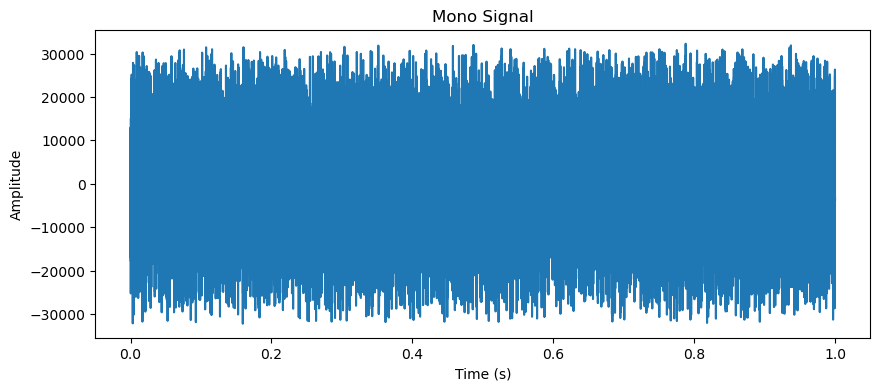

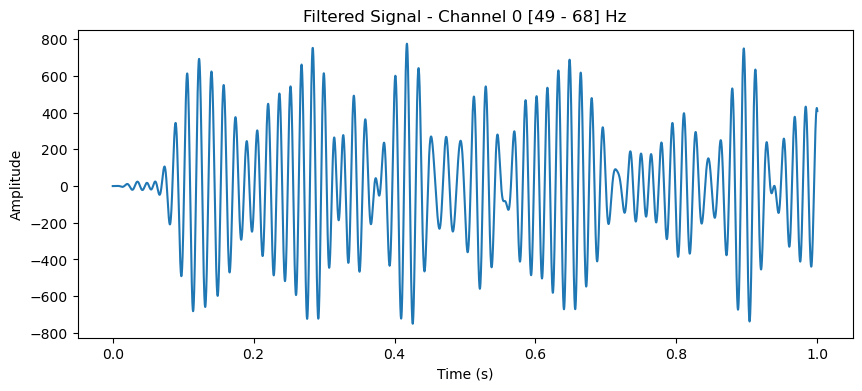

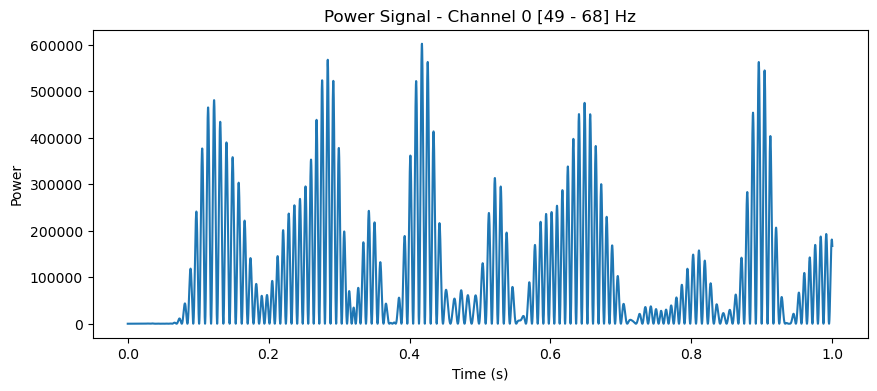

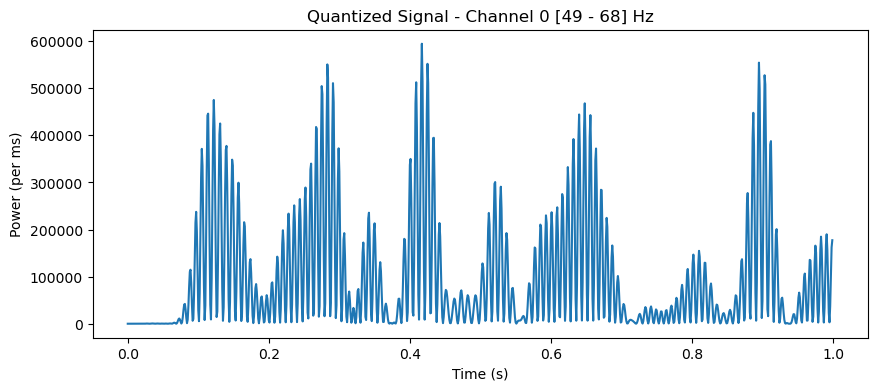

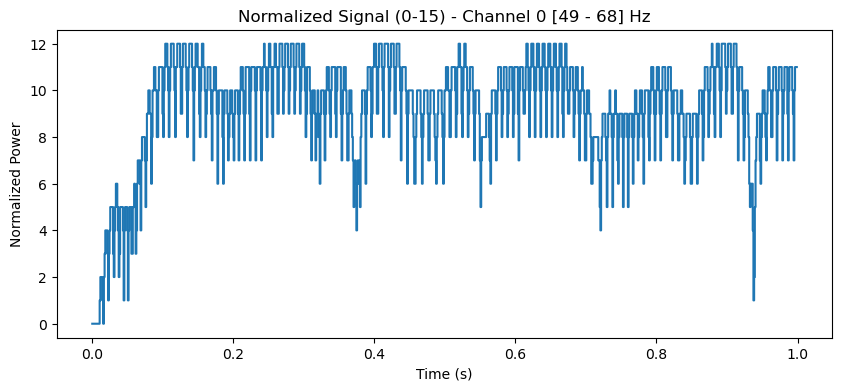

In [2]:
# Paths
input_wav_path = "data/RAW/CAFE-FOODCOURTB-2_clean.wav" 
output_dir = "data/PROCESSED_YES_COCHLEA/CUT/CAFE"

# Process the audio file
mono_signal, trimmed_signal, filtered, power_signals, quantized, normalized, freqs, output_csv_path = process_audio_file(input_wav_path, output_dir)

# If you want to inspect intermediate results via plots:
plot_mono_signal(mono_signal, 48000, start_sec=0, duration_sec=1)
plot_filtered_signal_one_channel(filtered, 48000, freqs, channel=0, start_sec=0, duration_sec=1)
plot_power_signal_one_channel(power_signals, 48000, freqs, channel=0, start_sec=0, duration_sec=1)
plot_quantized_signal_one_channel(quantized, freqs, channel=0, start_ms=0, duration_ms=1000)
plot_normalized_signal_one_channel(normalized, freqs, channel=0, start_ms=0, duration_ms=1000)

# Segment the CSV file
original_filename_no_ext = os.path.splitext(os.path.basename(input_wav_path))[0]
segment_csv_file(output_csv_path, original_filename_no_ext)